<a href="https://colab.research.google.com/github/sallyMo14/Prediction-of-Employees-Income/blob/main/Prediction_of_Employees_Income_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(transform_output='pandas')
from imblearn.over_sampling import SMOTE


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Predefined functions

In [3]:
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None, yticks = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names

  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}")

  # Set custom yticks if provided
  if yticks is not None:
      ax.set_yticks(yticks)

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

In [4]:
def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

In [5]:
# Final version of function
def plot_categorical_vs_target(df, x, y='SalePrice',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray',colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap,colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [7]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):

    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_

    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)

    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)

    return importances

#Explore data set

In [8]:
file_path="/content/drive/MyDrive/AXSOSACADEMY/AXSOSACADEMY/05-IntermediateML/Week17/Data/adult.csv"
df=pd.read_csv(file_path)
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [9]:
#Check for data columns data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [10]:
#Check for null values
df.isna().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


In [11]:
#check for dublicates
df.duplicated().sum()

np.int64(52)

In [12]:
#drop duplicates
df.drop_duplicates(inplace=True)

In [13]:
df.duplicated().sum()

np.int64(0)

#Check for consistency

In [14]:
for col in df.columns:
 print(col)
 print(df[col].unique())
 print("----------------------------------")

age
[25 38 28 44 18 34 29 63 24 55 65 36 26 58 48 43 20 37 40 72 45 22 23 54
 32 46 56 17 39 52 21 42 33 30 47 41 19 69 50 31 59 49 51 27 57 61 64 79
 73 53 77 80 62 35 68 66 75 60 67 71 70 90 81 74 78 82 83 85 76 84 89 88
 87 86]
----------------------------------
workclass
['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
----------------------------------
fnlwgt
[226802  89814 336951 ... 129912 255835 257302]
----------------------------------
education
['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
----------------------------------
educational-num
[ 7  9 12 10  6 15  4 13 14 16  3 11  5  8  2  1]
----------------------------------
marital-status
['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']
--------------------------------

In [15]:
#replace ? with unknown
df['occupation'].replace('?', 'unknown', inplace=True)
df['native-country'].replace('?', 'unknown', inplace=True)
df['workclass'].replace('?', 'unknown', inplace=True)

/tmp/ipython-input-4245897927.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['occupation'].replace('?', 'unknown', inplace=True)
/tmp/ipython-input-4245897927.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [16]:
for col in df.columns:
 print(col)
 print(df[col].unique())
 print("----------------------------------")

age
[25 38 28 44 18 34 29 63 24 55 65 36 26 58 48 43 20 37 40 72 45 22 23 54
 32 46 56 17 39 52 21 42 33 30 47 41 19 69 50 31 59 49 51 27 57 61 64 79
 73 53 77 80 62 35 68 66 75 60 67 71 70 90 81 74 78 82 83 85 76 84 89 88
 87 86]
----------------------------------
workclass
['Private' 'Local-gov' 'unknown' 'Self-emp-not-inc' 'Federal-gov'
 'State-gov' 'Self-emp-inc' 'Without-pay' 'Never-worked']
----------------------------------
fnlwgt
[226802  89814 336951 ... 129912 255835 257302]
----------------------------------
education
['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
----------------------------------
educational-num
[ 7  9 12 10  6 15  4 13 14 16  3 11  5  8  2  1]
----------------------------------
marital-status
['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']
--------------------------

#Check for imposible values

In [17]:
df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48790.000000,4.879000e+04,48790.000000,48790.000000,48790.000000,48790.000000
mean,38.652798,1.896690e+05,10.078807,1080.217688,87.595573,40.425886
std,13.708493,1.056172e+05,2.570046,7455.905921,403.209129,12.392729
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781385e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376062e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


#Exploratory Visualizations

In [18]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

##Age



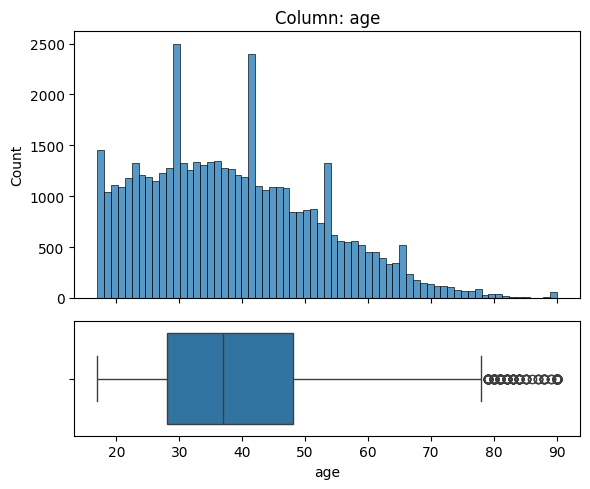

- NaN's Found: 0 (0.0%)


In [19]:
explore_numeric(df, 'age')

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Numeric
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * Not applicable
* What is the cardinality? Is it high?
  * Not ablicable
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

##Workclass


 * workclass:
    * Private
    * Self-emp-not-inc
    * Self-emp-inc
    * Federal-gov
    * Local-gov
    * State-gov
    * Without-pay
    * Never-worked.

/tmp/ipython-input-2460091364.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


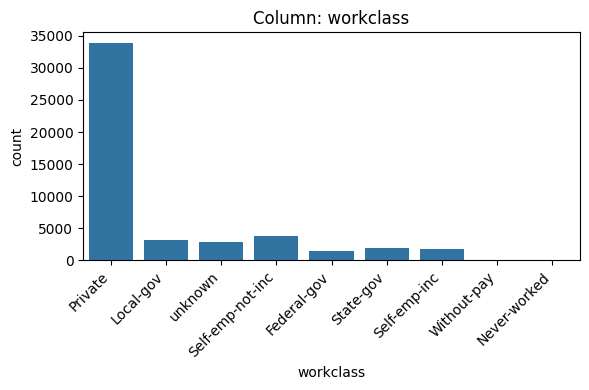

- NaN's Found: 0 (0.0%)
- Unique Values: 9
- Most common value: 'Private' occurs 33860 times (69.4%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: workclass'}, xlabel='workclass', ylabel='count'>)

In [20]:
explore_categorical(df, 'workclass')

* Most adults work in a private busniss

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Categorical
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No


##fnlwgt



* How many population does this row represents from the sample

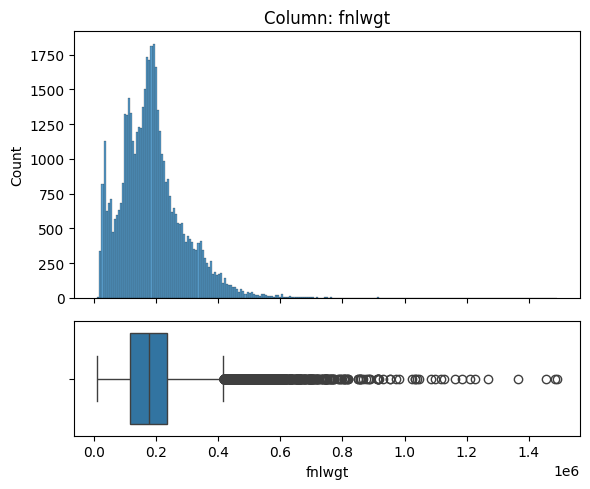

- NaN's Found: 0 (0.0%)


In [21]:
explore_numeric(df, 'fnlwgt')

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Numerical
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * Not applicable
* What is the cardinality? Is it high?
  * Not applicable
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * Yes , it should not be included in the modeling process , because it does not have any relation of the modeling process  


##Education


*  Bachelors
* Some-college
* 11th, HS-grad
* Prof-school
* Assoc-acdm
* Assoc-voc
* 9th
* 7th-8th
* 12th
*  Masters
* 1st-4th
* 10th
* Doctorate
* 5th-6th
* Preschool

/tmp/ipython-input-2460091364.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


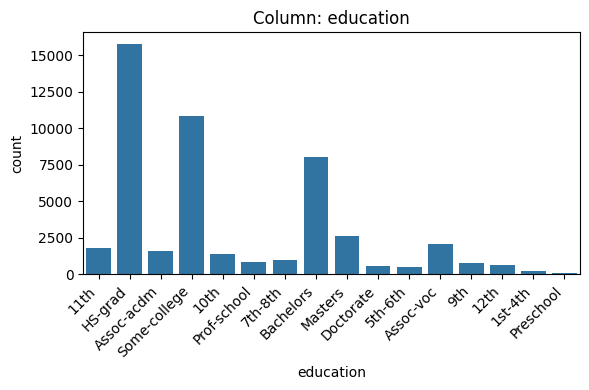

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'HS-grad' occurs 15770 times (32.32%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: education'}, xlabel='education', ylabel='count'>)

In [22]:
explore_categorical(df, 'education')

* Most adults have finished High scool or collage or bachelors

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Categorical
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No


##educational-num


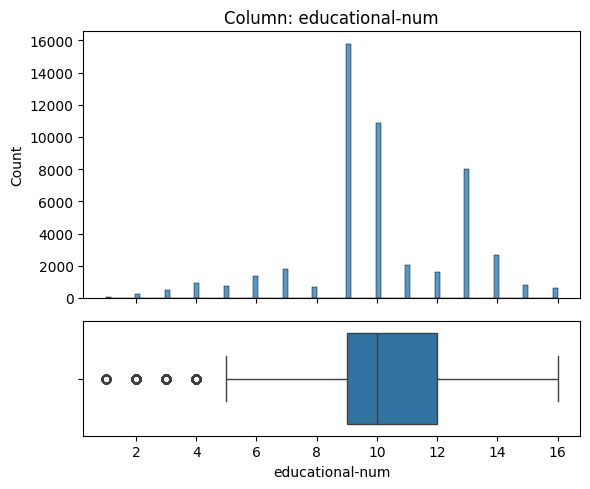

- NaN's Found: 0 (0.0%)


In [23]:
explore_numeric(df, 'educational-num')

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Numeric
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * Not applicable
* What is the cardinality? Is it high?
  * Not applicable
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * I am not sure , i think there is a multicoleniarity between educational-num and education


##marital-status :


* Married-civ-spouse
* Divorced
* Never-married
* Separated
* Widowed
* Married-spouse-absent
* Married-AF-spouse

/tmp/ipython-input-2460091364.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


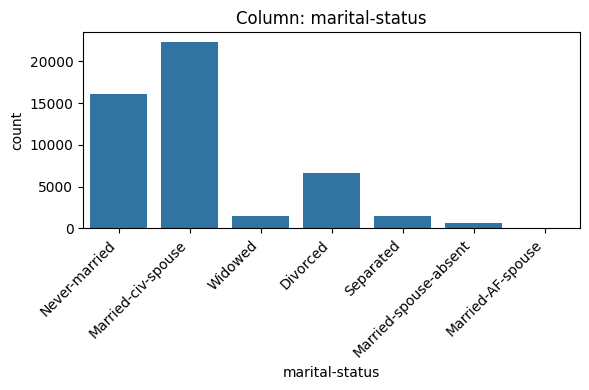

- NaN's Found: 0 (0.0%)
- Unique Values: 7
- Most common value: 'Married-civ-spouse' occurs 22366 times (45.84%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: marital-status'}, xlabel='marital-status', ylabel='count'>)

In [24]:
explore_categorical(df, 'marital-status')

* Most adults are Married-civ-spouse

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Ctegorical
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

##occupation


 * Tech-support
 * Craft-repair
 * Other-service
 * Sales
 * Exec-managerial
 * Prof-specialty
 * Handlers-cleaners
 * Machine-op-inspct
 * Adm-clerical
 * Farming-fishing
 * Transport-moving
 * Priv-house-serv
 * Protective-serv
 * Armed-Forces.

/tmp/ipython-input-2460091364.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


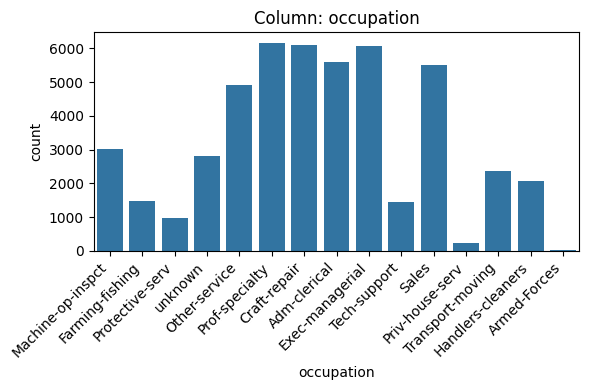

- NaN's Found: 0 (0.0%)
- Unique Values: 15
- Most common value: 'Prof-specialty' occurs 6165 times (12.64%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: occupation'}, xlabel='occupation', ylabel='count'>)

In [25]:
explore_categorical(df, 'occupation')

* Most addults work as prof-speciality , craft-repair ,adm-clerical , sales Exec-managerial
* Least adults work as Priv-house-serv

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Ctegorical
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

## relationship :


* Wife
* Own-child
* Husband
* Not-in-family
* Other-relative
* Unmarried

/tmp/ipython-input-2460091364.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


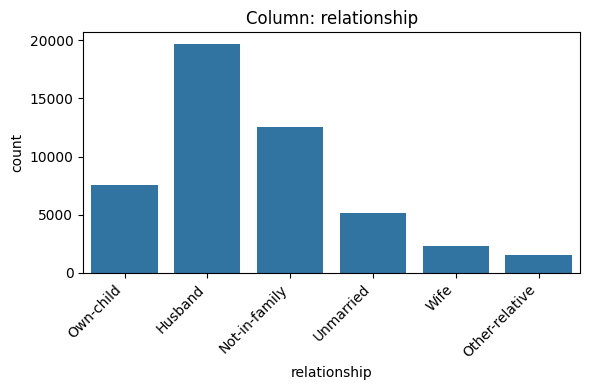

- NaN's Found: 0 (0.0%)
- Unique Values: 6
- Most common value: 'Husband' occurs 19703 times (40.38%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: relationship'}, xlabel='relationship', ylabel='count'>)

In [26]:
explore_categorical(df, 'relationship')

* Most adults are married males
* There is a very obvious difference between husbands and wives

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Ctegorical
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

##race:


* White
* Asian-Pac-Islander
* Amer-Indian-Eskimo
* Other
* Black.

/tmp/ipython-input-2460091364.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


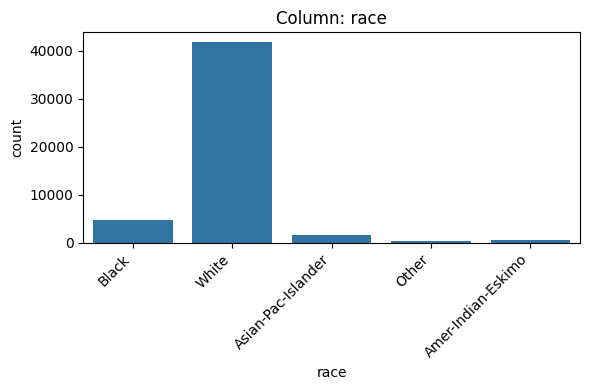

- NaN's Found: 0 (0.0%)
- Unique Values: 5
- Most common value: 'White' occurs 41714 times (85.5%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: race'}, xlabel='race', ylabel='count'>)

In [27]:
explore_categorical(df, 'race')

* Most employyes are white
* There is a very big difference between white people and other races (black,asian-pac-islander , amer-indian-eskimo and other)


* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Ctegorical
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

##gender:


* Female
* Male

/tmp/ipython-input-2460091364.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


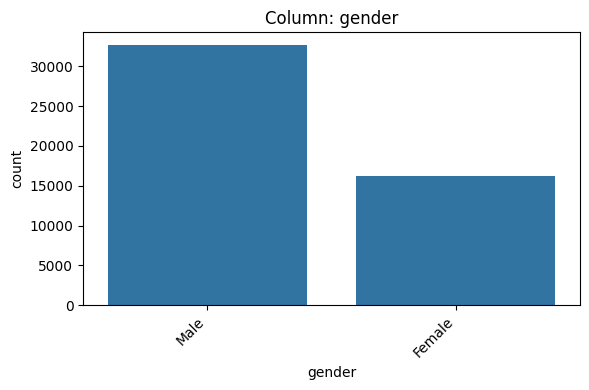

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Male' occurs 32614 times (66.85%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: gender'}, xlabel='gender', ylabel='count'>)

In [28]:
explore_categorical(df, 'gender')

* Males are almost twice females

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Ctegorical
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

##capital-gain

* Income from investment sources

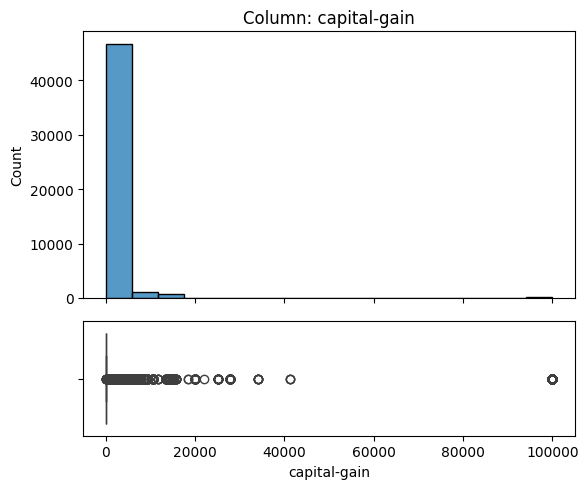

- NaN's Found: 0 (0.0%)


In [29]:
explore_numeric(df, 'capital-gain')

In [30]:
max_capital_gain_filter=df['capital-gain'] == df['capital-gain'].max()
max_capital_gain_row = df[max_capital_gain_filter]
max_capital_gain_row

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
83,44,Self-emp-inc,223881,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,99999,0,50,unknown,>50K
346,39,Private,198654,HS-grad,9,Divorced,Exec-managerial,Unmarried,Black,Female,99999,0,40,United-States,>50K
357,50,Self-emp-not-inc,165001,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,80,United-States,>50K
418,54,Self-emp-inc,159219,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,40,United-States,>50K
692,41,Private,191547,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,55,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48109,47,Private,155664,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,55,United-States,>50K
48253,43,Self-emp-inc,62026,Prof-school,15,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,40,United-States,>50K
48371,66,Private,115498,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,55,unknown,>50K
48519,47,Private,294913,Prof-school,15,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,40,United-States,>50K


* Probably We should drop the row with the very extreme capital-gain inorder to view the destribution more clear, but they are too many rows (244) , so we will keep them .

In [31]:
df['capital-gain'].value_counts(normalize=True)

,proportion
capital-gain,
0,0.917299
15024,0.010514
7688,0.008403
7298,0.007461
99999,0.005001
...,...
6612,0.000020
1111,0.000020
22040,0.000020


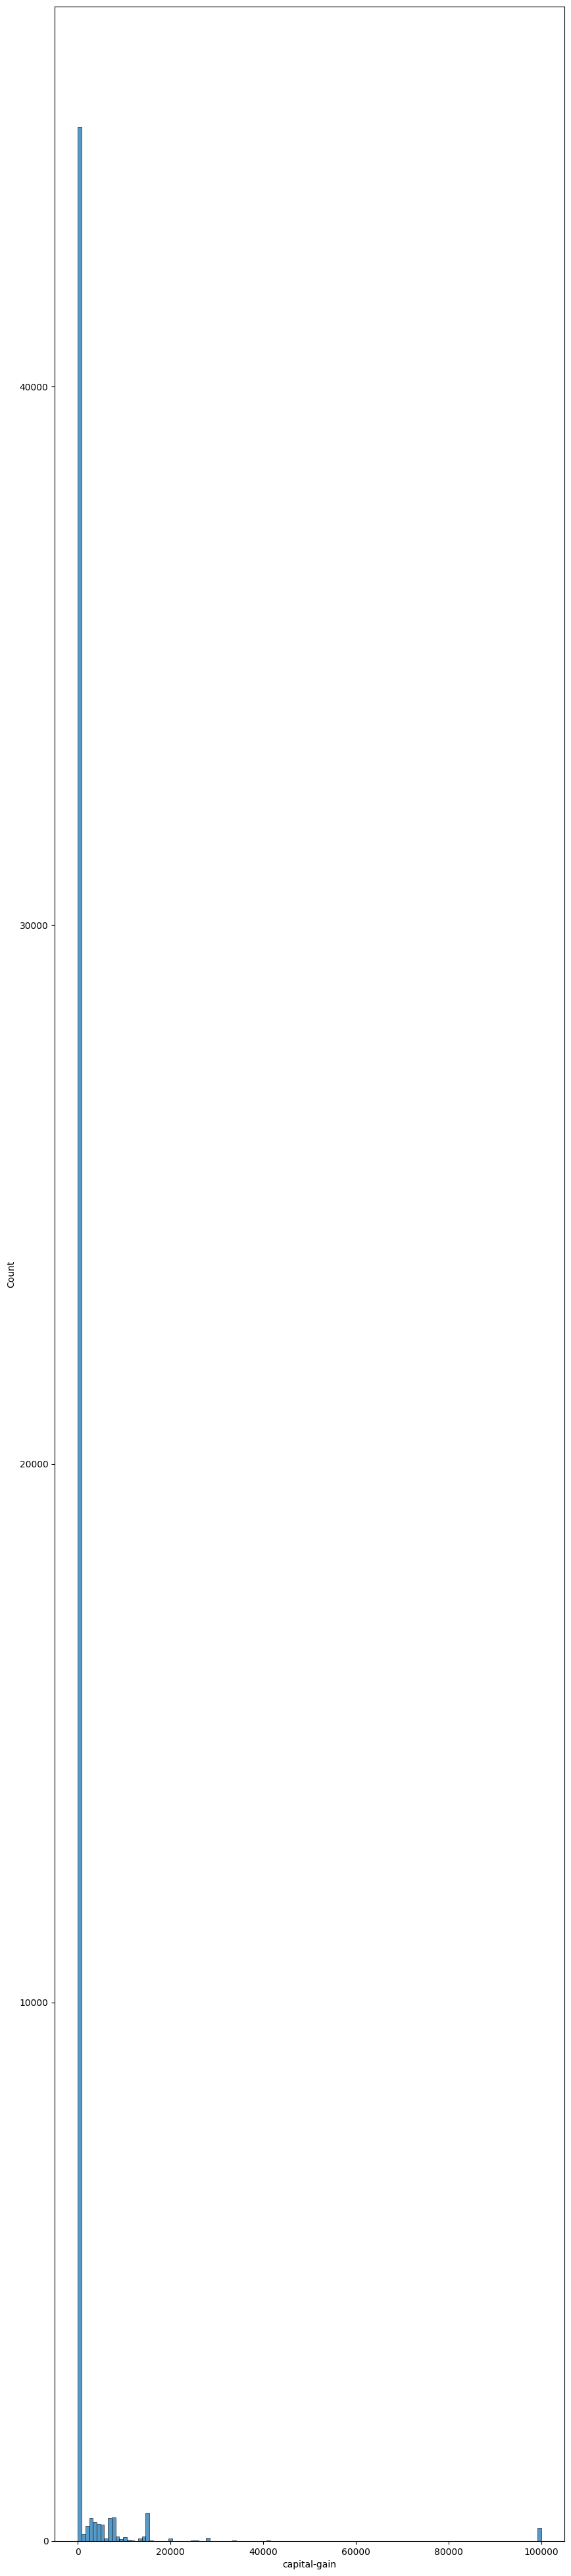

In [32]:
plt.figure(figsize=(10, 50))
ax=sns.histplot(data=df, x='capital-gain', bins=123)


* The majority of the adults do not have any capital gane at all
* There are some adults that have extreme capital gain (99999)


* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Numeric
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

## capital-loss

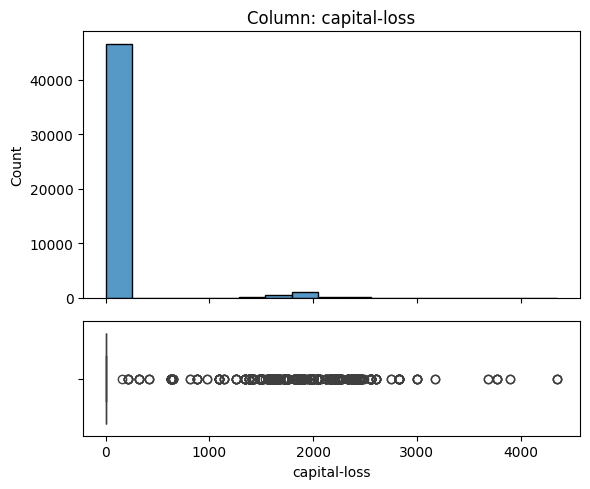

- NaN's Found: 0 (0.0%)


In [33]:
explore_numeric(df, 'capital-loss')

In [34]:
df['capital-loss'].value_counts(normalize=True)

,proportion
capital-loss,
0,0.953228
1902,0.006231
1977,0.005185
1887,0.004776
2415,0.001476
...,...
1539,0.000020
2489,0.000020
2080,0.000020


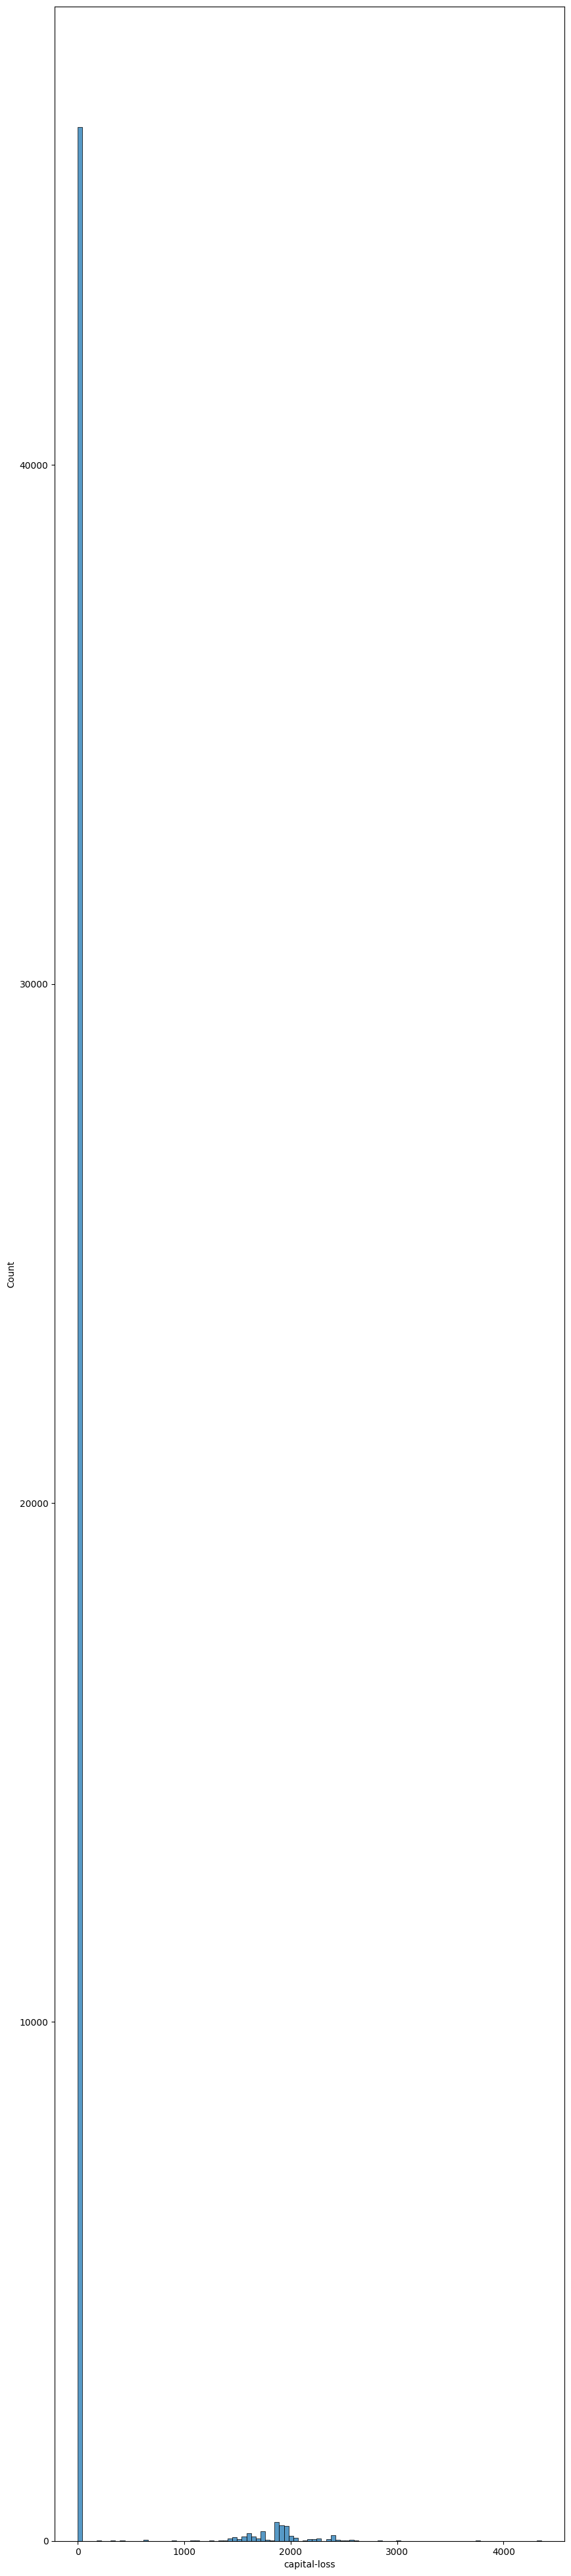

In [35]:
plt.figure(figsize=(10, 50))
ax=sns.histplot(data=df, x='capital-loss', bins=99)


 * most adults have zero capital-loss , I thinks this is related to the capital-gain (people with zero capital-gain , will probably have zero capital-loss) -> Most people do not sell investments .
 * There second most capital - losis around 2k

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Numeric
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

##hours-per-week

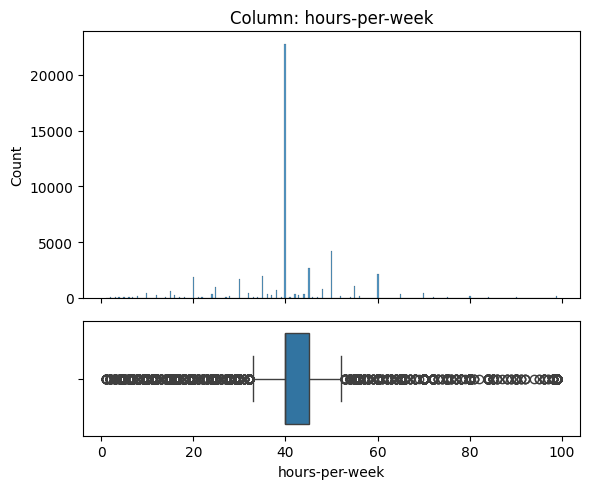

- NaN's Found: 0 (0.0%)


In [36]:
explore_numeric(df, 'hours-per-week')

* The majority of the adults work 40 houers per week
* the hours-per-week values is widly distributed between 0-100 hours per week

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Numeric
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

##native-country

In [37]:
native_country_order=df['native-country'].value_counts().sort_values(ascending=False)
native_country_order.index

Index(['United-States', 'Mexico', 'unknown', 'Philippines', 'Germany',
       'Puerto-Rico', 'Canada', 'El-Salvador', 'India', 'Cuba', 'England',
       'China', 'South', 'Jamaica', 'Italy', 'Dominican-Republic', 'Japan',
       'Poland', 'Vietnam', 'Guatemala', 'Columbia', 'Haiti', 'Portugal',
       'Taiwan', 'Iran', 'Nicaragua', 'Greece', 'Peru', 'Ecuador', 'France',
       'Ireland', 'Thailand', 'Hong', 'Cambodia', 'Trinadad&Tobago', 'Laos',
       'Outlying-US(Guam-USVI-etc)', 'Yugoslavia', 'Scotland', 'Honduras',
       'Hungary', 'Holand-Netherlands'],
      dtype='object', name='native-country')

/tmp/ipython-input-2460091364.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


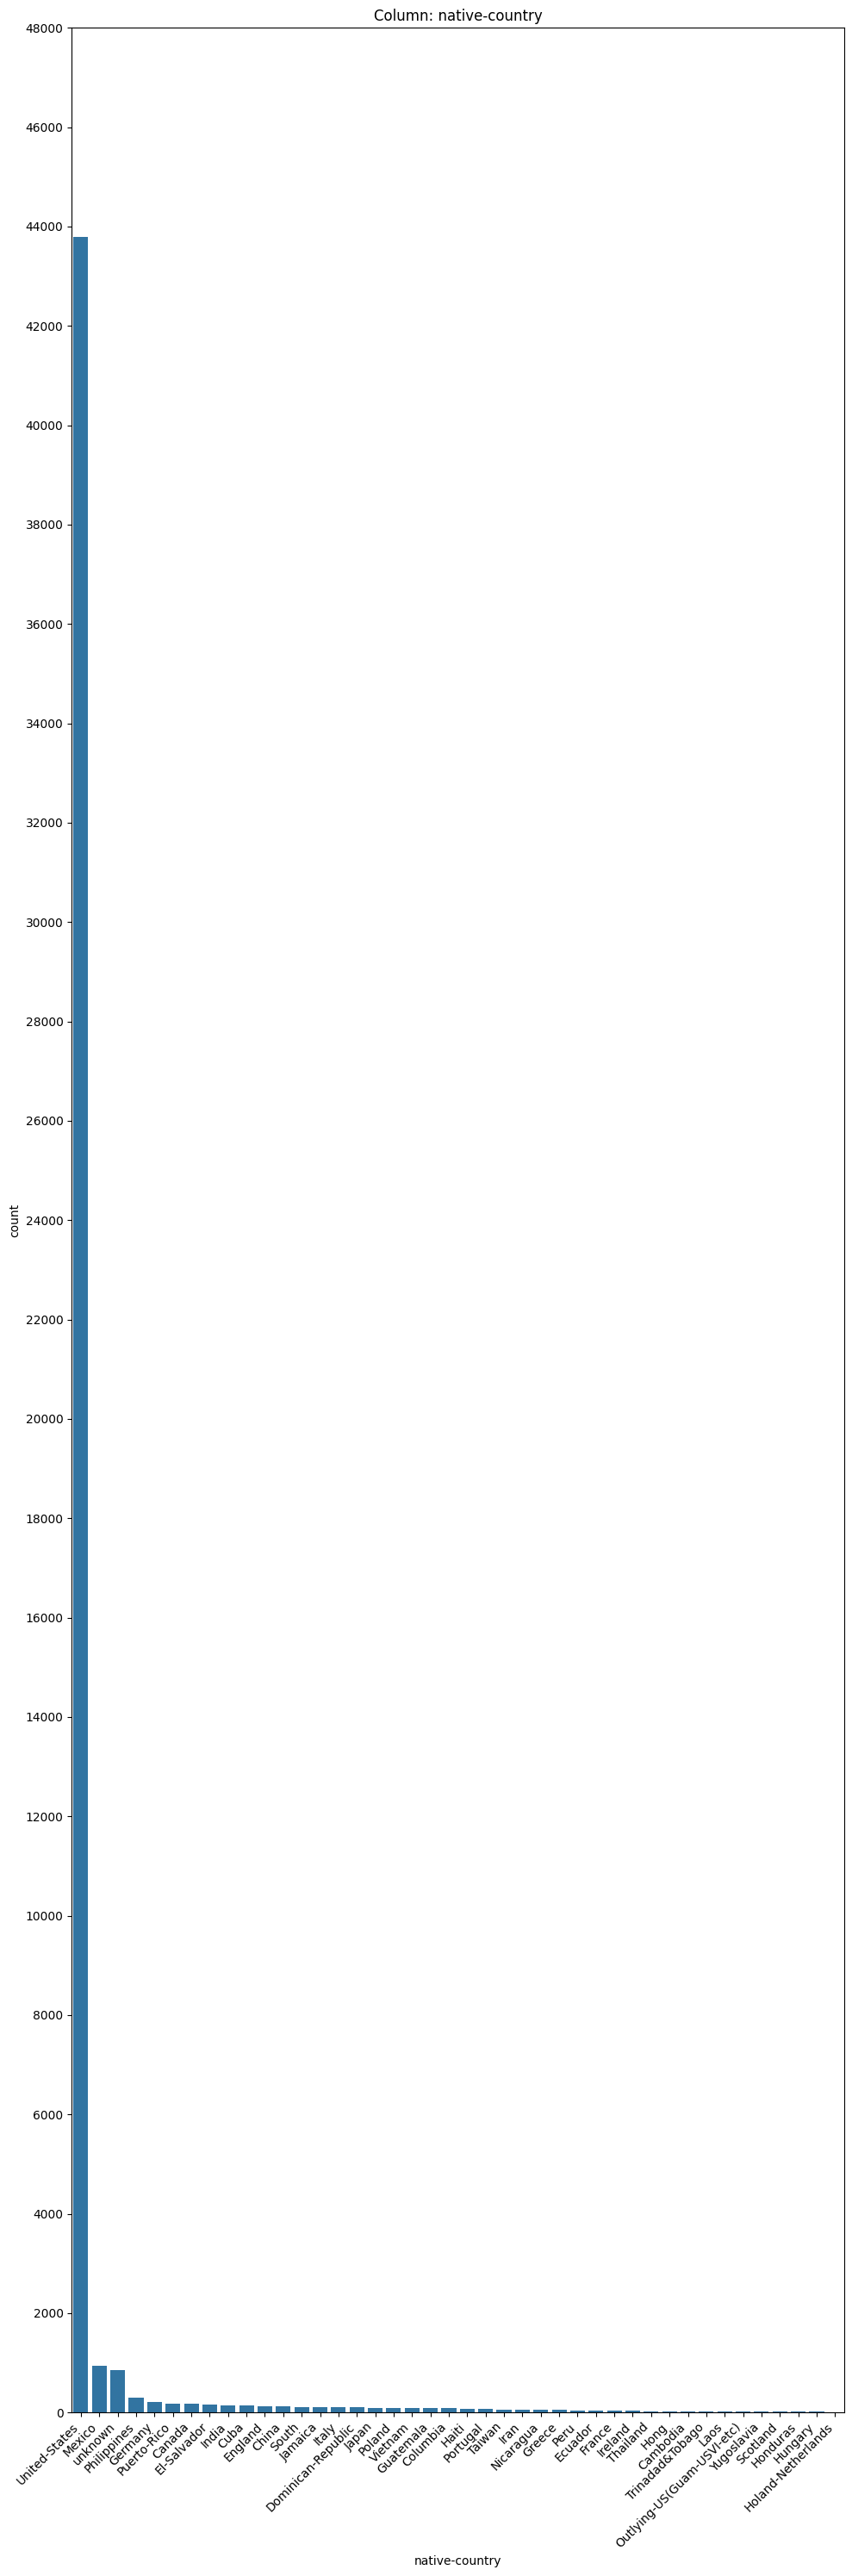

- NaN's Found: 0 (0.0%)
- Unique Values: 42
- Most common value: 'United-States' occurs 43792 times (89.76%)
- Not constant or quasi-constant.


(<Figure size 1000x3000 with 1 Axes>,
 <Axes: title={'center': 'Column: native-country'}, xlabel='native-country', ylabel='count'>)

In [38]:

explore_categorical(df, 'native-country', figsize=(10, 30), yticks=range(0, 50000, 2000),order=native_country_order.index)

* Most adults are from united states (almost 90%)

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Categorical
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * it is moderate(42) , regarding to the size of the data (48790 rows)
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * Maybe , because it has a very high cardinality , and most people are from united states ,  i think it will affect the quality of the model padly , as it may confuse and mislead the model

In [39]:
df['native-country'].value_counts(normalize=True)

,proportion
native-country,
United-States,0.897561
Mexico,0.019328
unknown,0.017545
Philippines,0.006026
Germany,0.004222
Puerto-Rico,0.003771
Canada,0.003730
El-Salvador,0.003177
India,0.003095


##Income

/tmp/ipython-input-2460091364.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


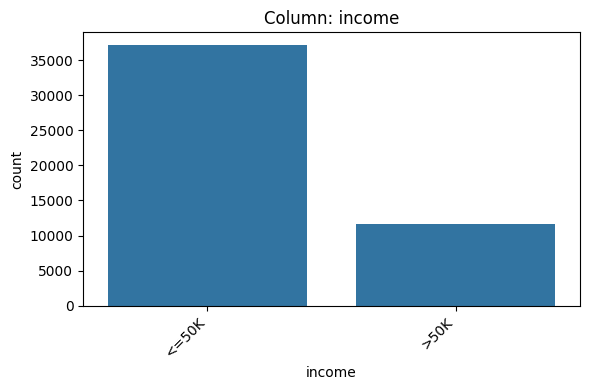

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '<=50K' occurs 37109 times (76.06%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: income'}, xlabel='income', ylabel='count'>)

In [40]:
explore_categorical(df,'income')

* There data are not balanced

#Preprocessing

In [41]:
y=df['income']
X=df.drop(['income','fnlwgt'], axis=1)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
num_cols=X_train.select_dtypes(include=['number']).columns
ord_cols=['education']
cat_cols=X_train.select_dtypes(include=['object']).columns.drop(ord_cols)
display(num_cols,ord_cols,cat_cols)

Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

['education']

Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object')

##Preprocessing of numerical features

In [44]:
scaler=StandardScaler()
num_tuple=('numeric',scaler,num_cols)

##Preproessing of ordinal data

In [45]:
df[ord_cols].value_counts()

,count
education,
HS-grad,15770
Some-college,10863
Bachelors,8013
Masters,2656
Assoc-voc,2060
11th,1812
Assoc-acdm,1601
10th,1389
7th-8th,954


In [46]:
education_order = [
    'Preschool',
    '1st-4th',
    '5th-6th',
    '7th-8th',
    '9th',
    '10th',
    '11th',
    '12th',
    'HS-grad',
    'Some-college',
    'Assoc-voc',
    'Assoc-acdm',
    'Bachelors',
    'Masters',
    'Prof-school',
    'Doctorate'
]
ord_encoder = OrdinalEncoder(categories=[education_order])
scaler=StandardScaler()
ord_pipe=Pipeline([('ordinal_encoder',ord_encoder),('scaler',scaler)])
ord_tuple=('ordinal',ord_pipe,ord_cols)
ord_pipe

Pipeline(steps=[('ordinal_encoder',
                 OrdinalEncoder(categories=[['Preschool', '1st-4th', '5th-6th',
                                             '7th-8th', '9th', '10th', '11th',
                                             '12th', 'HS-grad', 'Some-college',
                                             'Assoc-voc', 'Assoc-acdm',
                                             'Bachelors', 'Masters',
                                             'Prof-school', 'Doctorate']])),
                ('scaler', StandardScaler())])

##Preprocessing of categorical data


In [47]:
ohe_encoder=OneHotEncoder(handle_unknown='ignore',sparse_output=False)
ohe_tuple=('categorical',ohe_encoder,cat_cols)

In [48]:
col_trans=ColumnTransformer([num_tuple,ord_tuple,ohe_tuple],verbose_feature_names_out=False)
X_train_tf=col_trans.fit_transform(X_train)
X_test_tf=col_trans.transform(X_test)
col_trans

ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                 Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['Preschool',
                                                                              '1st-4th',
                                                                              '5th-6th',
                                                                              '7th-8th',
                                                                              '9th',
                                                                              '10th',
                                                                              '11th',
                                                                              '12th',
                                                                              'HS-grad',
                                                                              'Some-college',
                                                                              'Assoc-voc',
                                                                              'Assoc-acdm',
                                                                              'Bachelors',
                                                                              'Masters',
                                                                              'Prof-school',
                                                                              'Doctorate']])),
                                                 ('scaler', StandardScaler())]),
                                 ['education']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [49]:
X_train_tf.head()

,age,educational-num,capital-gain,capital-loss,hours-per-week,education,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,native-country_unknown
6356,1.190819,-0.423242,-0.145529,-0.217785,-0.036552,-0.423242,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6522,-1.365570,-0.034463,-0.145529,-0.217785,-0.036552,-0.034463,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9289,-0.343014,-2.367136,-0.145529,-0.217785,-0.036552,-2.367136,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14861,0.606501,1.520652,-0.145529,-0.217785,-0.036552,1.520652,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
43274,-0.123895,0.354315,-0.145529,-0.217785,0.124340,0.354315,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


LogisticRegression()
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91     29669
        >50K       0.73      0.60      0.66      9363

    accuracy                           0.85     39032
   macro avg       0.81      0.77      0.78     39032
weighted avg       0.85      0.85      0.85     39032



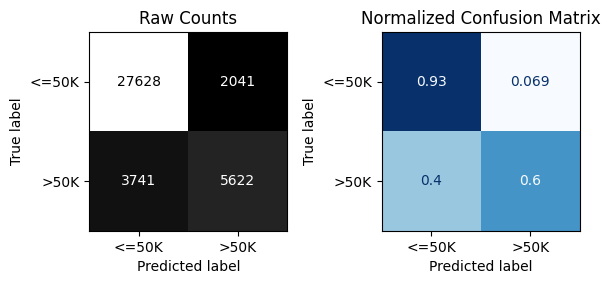


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      7440
        >50K       0.74      0.59      0.66      2318

    accuracy                           0.85      9758
   macro avg       0.81      0.76      0.78      9758
weighted avg       0.85      0.85      0.85      9758



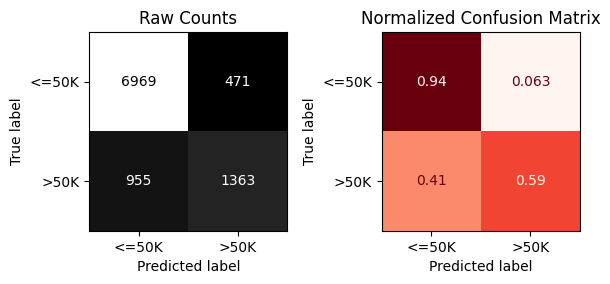

----------------------------------------------------------------------------------------------------------------------
RandomForestClassifier()
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.98      0.99      0.98     29669
        >50K       0.96      0.93      0.94      9363

    accuracy                           0.97     39032
   macro avg       0.97      0.96      0.96     39032
weighted avg       0.97      0.97      0.97     39032



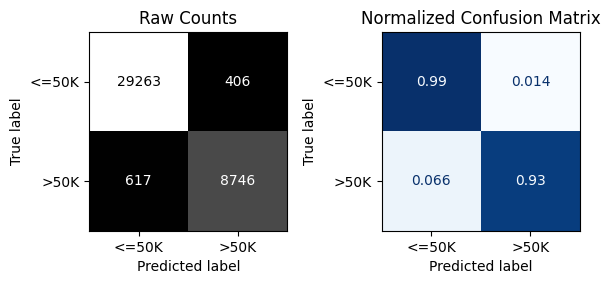


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.89      0.92      0.90      7440
        >50K       0.71      0.63      0.67      2318

    accuracy                           0.85      9758
   macro avg       0.80      0.77      0.79      9758
weighted avg       0.85      0.85      0.85      9758



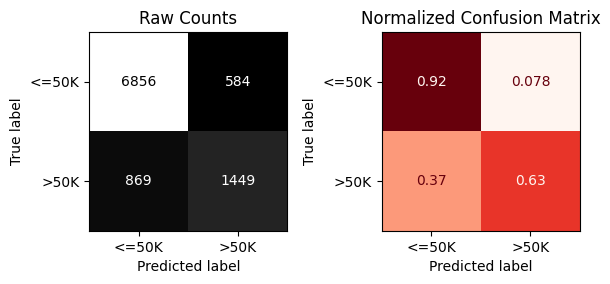

----------------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier()
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.97      0.99      0.98     29669
        >50K       0.98      0.91      0.94      9363

    accuracy                           0.97     39032
   macro avg       0.98      0.95      0.96     39032
weighted avg       0.97      0.97      0.97     39032



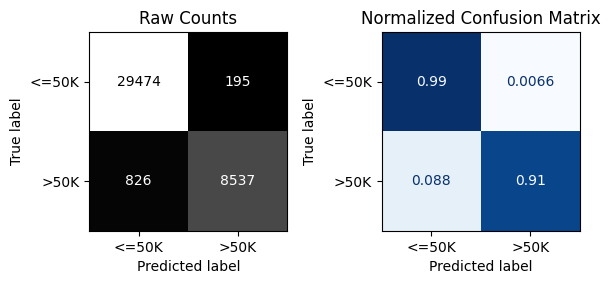


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.89      0.89      7440
        >50K       0.64      0.61      0.62      2318

    accuracy                           0.83      9758
   macro avg       0.76      0.75      0.75      9758
weighted avg       0.82      0.83      0.82      9758



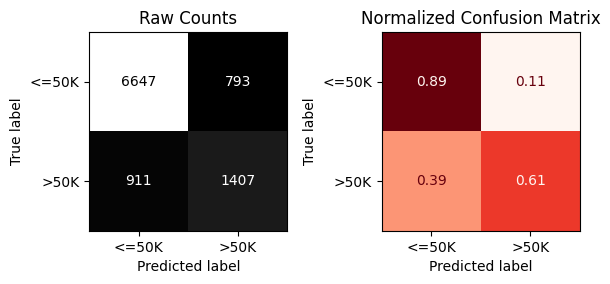

----------------------------------------------------------------------------------------------------------------------
KNeighborsClassifier()
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.91      0.94      0.92     29669
        >50K       0.79      0.70      0.74      9363

    accuracy                           0.88     39032
   macro avg       0.85      0.82      0.83     39032
weighted avg       0.88      0.88      0.88     39032



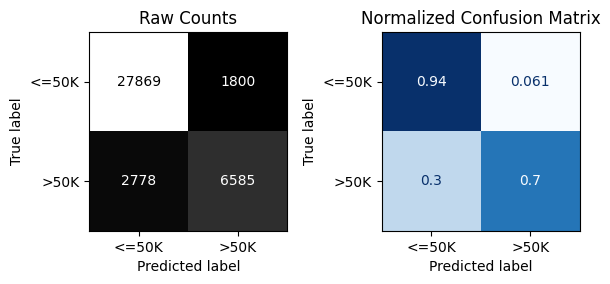


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      7440
        >50K       0.69      0.60      0.64      2318

    accuracy                           0.84      9758
   macro avg       0.78      0.76      0.77      9758
weighted avg       0.84      0.84      0.84      9758



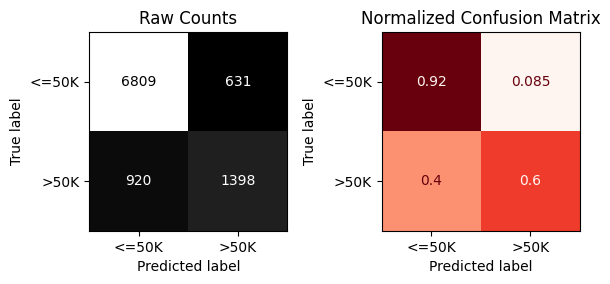

----------------------------------------------------------------------------------------------------------------------


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

models=[LogisticRegression(),RandomForestClassifier(),DecisionTreeClassifier(),KNeighborsClassifier()]
for model in models :
  print(model)
  model.fit(X_train_tf,y_train)
  evaluate_classification(model,X_train_tf, y_train,X_test_tf,y_test)
  print('----------------------------------------------------------------------------------------------------------------------')


* RandomForestClassifier() is the best model foe unbalanced data

In [51]:
smote=SMOTE()
X_train_smote,y_train_smote=smote.fit_resample(X_train_tf,y_train)

LogisticRegression()
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.84      0.80      0.82     29669
        >50K       0.81      0.85      0.83     29669

    accuracy                           0.82     59338
   macro avg       0.83      0.82      0.82     59338
weighted avg       0.83      0.82      0.82     59338



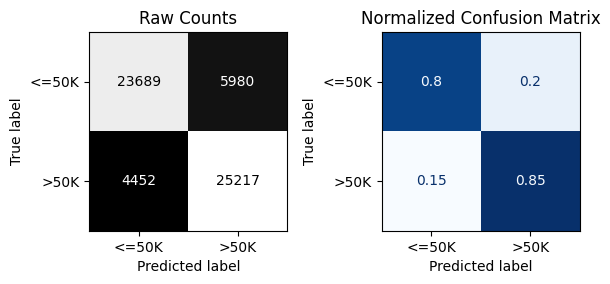


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.87      7440
        >50K       0.57      0.84      0.68      2318

    accuracy                           0.81      9758
   macro avg       0.75      0.82      0.77      9758
weighted avg       0.85      0.81      0.82      9758



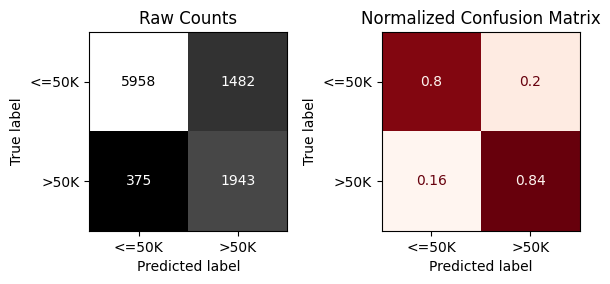

----------------------------------------------------------------------------------------------------------------------
RandomForestClassifier()
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.98      0.98      0.98     29669
        >50K       0.98      0.98      0.98     29669

    accuracy                           0.98     59338
   macro avg       0.98      0.98      0.98     59338
weighted avg       0.98      0.98      0.98     59338



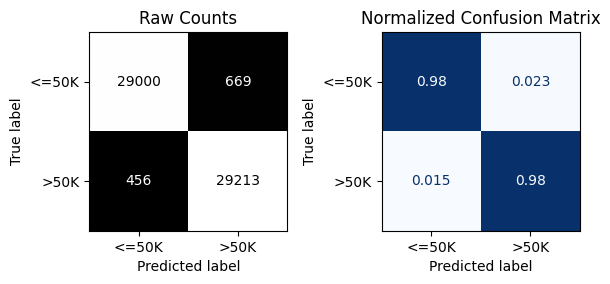


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.90      0.89      0.89      7440
        >50K       0.66      0.67      0.66      2318

    accuracy                           0.84      9758
   macro avg       0.78      0.78      0.78      9758
weighted avg       0.84      0.84      0.84      9758



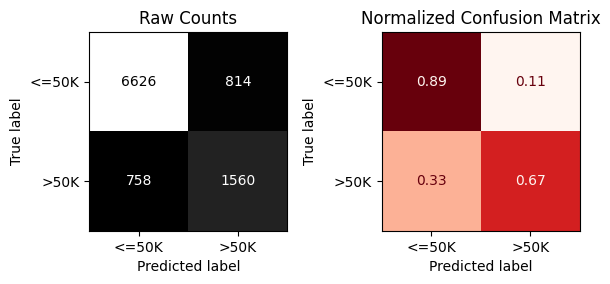

----------------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier()
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.98      0.99      0.98     29669
        >50K       0.99      0.97      0.98     29669

    accuracy                           0.98     59338
   macro avg       0.98      0.98      0.98     59338
weighted avg       0.98      0.98      0.98     59338



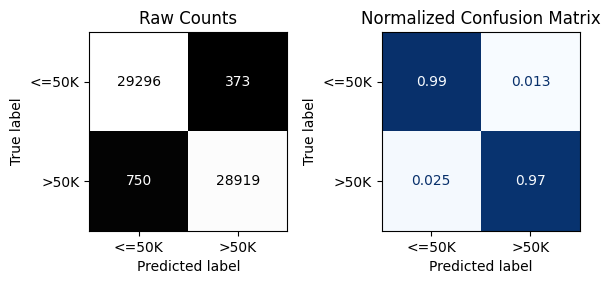


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.87      0.88      7440
        >50K       0.61      0.62      0.61      2318

    accuracy                           0.81      9758
   macro avg       0.74      0.75      0.75      9758
weighted avg       0.82      0.81      0.81      9758



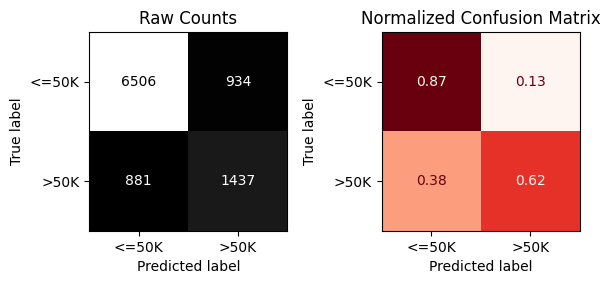

----------------------------------------------------------------------------------------------------------------------
KNeighborsClassifier()
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.94      0.85      0.90     29669
        >50K       0.87      0.95      0.90     29669

    accuracy                           0.90     59338
   macro avg       0.90      0.90      0.90     59338
weighted avg       0.90      0.90      0.90     59338



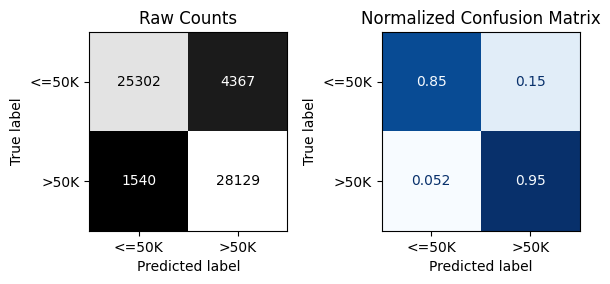


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.92      0.81      0.86      7440
        >50K       0.55      0.77      0.64      2318

    accuracy                           0.80      9758
   macro avg       0.74      0.79      0.75      9758
weighted avg       0.83      0.80      0.81      9758



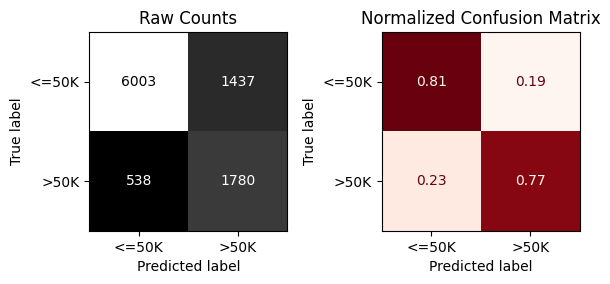

----------------------------------------------------------------------------------------------------------------------


In [52]:
models=[LogisticRegression(),RandomForestClassifier(),DecisionTreeClassifier(),KNeighborsClassifier()]
for model in models :
  print(model)
  model.fit(X_train_smote,y_train_smote)
  evaluate_classification(model,X_train_smote, y_train_smote,X_test_tf,y_test)
  print('----------------------------------------------------------------------------------------------------------------------')

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.98      0.98      0.98     29669
        >50K       0.98      0.98      0.98     29669

    accuracy                           0.98     59338
   macro avg       0.98      0.98      0.98     59338
weighted avg       0.98      0.98      0.98     59338



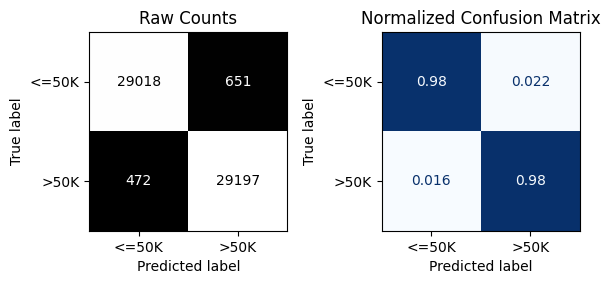


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.90      0.89      0.89      7440
        >50K       0.66      0.67      0.66      2318

    accuracy                           0.84      9758
   macro avg       0.78      0.78      0.78      9758
weighted avg       0.84      0.84      0.84      9758



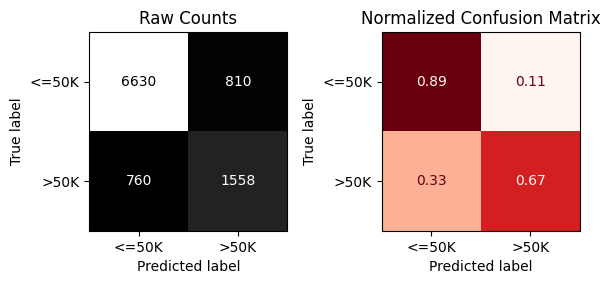

In [53]:
#The model with best quality
rf= RandomForestClassifier()
rf.fit(X_train_smote,y_train_smote)
evaluate_classification(rf,X_train_smote, y_train_smote,X_test_tf,y_test)

#Extract the 10 most importent features

In [54]:
rf.feature_importances_

array([2.04883647e-01, 7.72685886e-02, 6.16635992e-02, 1.92916186e-02,
       1.04981582e-01, 7.88209677e-02, 3.45667028e-03, 5.35471153e-03,
       1.97317653e-06, 1.01580846e-02, 4.67393551e-03, 7.50657834e-03,
       4.12251090e-03, 1.25903835e-04, 1.82360041e-03, 9.79762414e-03,
       3.19356440e-04, 9.44927698e-02, 1.13280868e-03, 3.94149122e-02,
       2.29958729e-03, 2.43533773e-03, 6.83952555e-03, 4.40566224e-05,
       6.35170158e-03, 1.70459133e-02, 5.53116098e-03, 3.86087082e-03,
       4.17810678e-03, 1.04123847e-02, 1.83969058e-04, 1.47299712e-02,
       2.27406412e-03, 6.66706163e-03, 3.55569942e-03, 4.27356821e-03,
       1.83543749e-03, 4.99663842e-02, 1.91297336e-02, 2.56452773e-03,
       2.15576357e-02, 9.29241106e-03, 1.07005150e-02, 1.51052534e-03,
       2.24517632e-03, 5.31756352e-03, 7.97738155e-04, 7.70124388e-03,
       1.03632092e-02, 1.25509586e-02, 1.80849997e-04, 8.93743943e-04,
       3.77413603e-04, 1.80011629e-04, 4.78992514e-04, 1.60352459e-04,
      

In [55]:
importances = get_importances(rf,sort=True,ascending=False)
importances.head(10)


,Feature Importance
age,0.204884
hours-per-week,0.104982
marital-status_Married-civ-spouse,0.094493
education,0.078821
educational-num,0.077269
capital-gain,0.061664
relationship_Husband,0.049966
marital-status_Never-married,0.039415
relationship_Own-child,0.021558
capital-loss,0.019292


In [56]:
importances.head(10).sum()

np.float64(0.7523417051748117)

In [57]:
top_ten_features=importances.head(10).index
top_ten_features

Index(['age', 'hours-per-week', 'marital-status_Married-civ-spouse',
       'education', 'educational-num', 'capital-gain', 'relationship_Husband',
       'marital-status_Never-married', 'relationship_Own-child',
       'capital-loss'],
      dtype='object')

* Some of these  features make sence :
  * As if one of these features increased , itis more commom that income will increase too :  
    * hours-per-week
    * education
    * capital-gain
    * educational-num
  * And if this function decreases , it is more common that income will increase :
    * capital-loss

/tmp/ipython-input-808541114.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),ha='right')


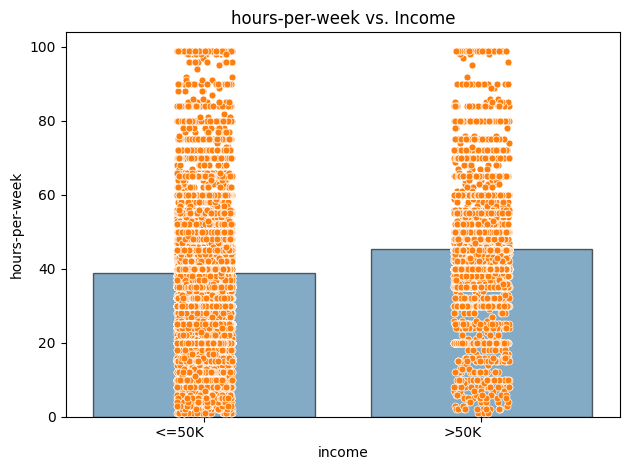

In [82]:
#Plot the relation between the hours per week and the income
fig, ax = plt.subplots()

    # Barplot
sns.barplot(data=df, y="hours-per-week", x='income', ax=ax, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
sns.stripplot(data=df, y='hours-per-week', x='income', ax=ax,
                edgecolor='white', linewidth=0.5,
                )
  # Rotate xlabels
ax.set_xticklabels(ax.get_xticklabels(),ha='right')

  # Add a title
ax.set_title('hours-per-week vs. Income')
fig.tight_layout()

<Axes: xlabel='income', ylabel='hours-per-week'>

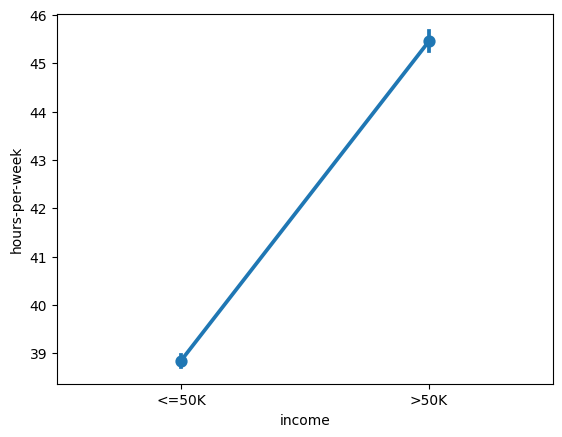

In [74]:
sns.pointplot(data=df, y="hours-per-week", x='income')

* People who gain > 50k income have mean of hours per week equals to  46
* People who gain <=50k income have mean of hours per week equals to 39
* The plot shows that the people who works more hours per week , are more probable to gain income > 50k

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'Preschool'),
  Text(1, 0, '1st-4th'),
  Text(2, 0, '5th-6th'),
  Text(3, 0, '7th-8th'),
  Text(4, 0, '9th'),
  Text(5, 0, '10th'),
  Text(6, 0, '11th'),
  Text(7, 0, '12th'),
  Text(8, 0, 'HS-grad'),
  Text(9, 0, 'Some-college'),
  Text(10, 0, 'Assoc-voc'),
  Text(11, 0, 'Assoc-acdm'),
  Text(12, 0, 'Bachelors'),
  Text(13, 0, 'Masters'),
  Text(14, 0, 'Prof-school'),
  Text(15, 0, 'Doctorate')])

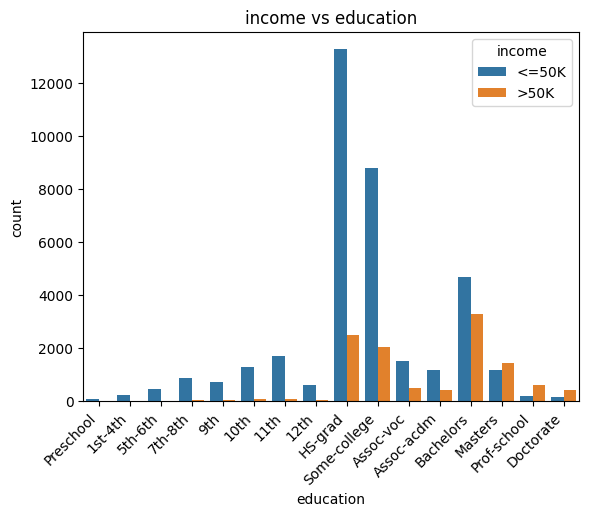

In [87]:
#education
sns.countplot(x='education', hue='income', data=df,order=education_order)
plt.title('income vs education')
plt.xticks(rotation=45,ha='right')
#plt.set_xticklabels(ax.get_xticklabels(),)

* The most categoris who gain income <=50k are HS_grads and collage grads
* The most categories who gains >50k income are Bechelors grads and HS_grads
* It seems like people who have higher degrees tend to have propbabilirty tp gain income > 50k